# Barnstable and Long-Run Risk

## HBS Case

### *The Risk of Stocks in the Long-Run: The Barnstable College Endowment*

***

# Section 2:
 Estimating Underperformance

### Data

Use the returns on the S&P 500 ($r^m$) and 1-month T-bills, ($r^f$) provided in `barnstable_analysis_data.xlsx`.
* Data goes through `END_YR=2024`.

Barnstable's estimates of mean and volatility are based on the subsample of 1965 to 1999.
* We consider this subsample, as well as 2000-{END_YR}, as well as the full sample of 1926-{END_YR}.

### Notation

* $r$ = level return rates
* $R$ = cumulative return factor
* $\texttt{r}$ = log return rates

$$ R \equiv 1+r$$

$$ \texttt{r} \equiv \ln(1+r) = \ln(R)$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw_df = pd.read_excel("../data/barnstable_analysis_data.xlsx", sheet_name="data")
raw_df.head()

,date,SPX,TB1M
0,1926-01-30,-0.001783,0.003061
1,1926-02-27,-0.033297,0.002612
2,1926-03-31,-0.057708,0.002601
3,1926-04-30,0.038522,0.002270
4,1926-05-28,0.013623,0.002691


### Question 1: Summary Statistics

(a) Report the following (annualized) statistics.

| | 1965-1999 | | | 2000-{END_YR} | | | 1926-{END_YR} | |
|---|---|---|---|---|---|---|---|---|
| | mean | vol | | mean | vol | | mean | vol |
| **levels** | $r^m$ | | | | | | | |
| | $\tilde{r}^m$ | | | | | | | |
| | $r^f$ | | | | | | | |
| **logs** | $\texttt{r}^m$ | | | | | | | |
| | $\tilde{\texttt{r}}^m$ | | | | | | | |
| | $\texttt{r}_f$ | | | | | | | |

In [3]:
# Question 2.1 Part (a) Here

import numpy as np
import pandas as pd

# Load data
df = pd.read_excel("../data/barnstable_analysis_data.xlsx", sheet_name="data")

# Rename columns for clarity
df = df.rename(columns={"SPX": "r_m", "TB1M": "r_f"})

# Extract year from the date
df["year"] = pd.to_datetime(df["date"]).dt.year

# Compute cumulative factors and log returns
df["r^_m"] = df["r_m"]-df["r_f"]
df["R_m"] = 1 + df["r_m"]
df["R^_m"] = 1 + df["r^_m"]
df["R_f"] = 1 + df["r_f"]
df["r_m_log"] = np.log(df["R_m"])
df["r^_m_log"] = np.log(df["R^_m"])
df["r_f_log"] = np.log(df["R_f"])


# Helper function to compute annualised mean and volatility
def summary_stats(data, start, end):
    subset = data[(data["year"] >= start) & (data["year"] <= end)]
    mean_stats = {
        "r_m": subset["r_m"].mean() * 12,
        "r^_m": subset["r^_m"].mean() * 12,
        "r_f": subset["r_f"].mean() * 12,
        "r_m_log": subset["r_m_log"].mean() * 12,
        "r^_m_log": subset["r^_m_log"].mean() * 12,
        "r_f_log": subset["r_f_log"].mean() * 12,
    }
    vol_stats = {
        "r_m": subset["r_m"].std(ddof=1) * np.sqrt(12),
        "r^_m": subset["r^_m"].std(ddof=1) * np.sqrt(12),
        "r_f": subset["r_f"].std(ddof=1) * np.sqrt(12),
        "r_m_log": subset["r_m_log"].std(ddof=1) * np.sqrt(12),
        "r^_m_log": subset["r^_m_log"].std(ddof=1) * np.sqrt(12),
        "r_f_log": subset["r_f_log"].std(ddof=1) * np.sqrt(12),
    }
    return pd.Series(mean_stats), pd.Series(vol_stats)

# Define sample periods
samples = [(1965, 1999), (2000, 2024), (1926, 2024)]

# Compute stats for each sample
m_stats_65_99, v_stats_65_99 = summary_stats(df, *samples[0])
m_stats_00_24, v_stats_00_24 = summary_stats(df, *samples[1])
m_stats_full, v_stats_full = summary_stats(df, *samples[2])

# Organise into table
table = pd.concat(
    [m_stats_65_99, v_stats_65_99, m_stats_00_24, v_stats_00_24, m_stats_full, v_stats_full],
    axis=1,                
    keys=['1965–1999: mean','1965–1999: vol', '2000–2024:mean', '2000–2024:vol', 'Full sample(1926-2024): mean', 'Full sample(1926-2024): vol']  
)
table


,1965–1999: mean,1965–1999: vol,2000–2024:mean,2000–2024:vol,Full sample(1926-2024): mean,Full sample(1926-2024): vol
r_m,0.129354,0.149405,0.087542,0.152815,0.115529,0.186650
r^_m,0.068660,0.150227,0.070091,0.153093,0.083308,0.187329
r_f,0.061503,0.007179,0.017451,0.005553,0.031928,0.008507
r_m_log,0.117600,0.149568,0.075553,0.153763,0.097821,0.185938
r^_m_log,0.057161,0.151207,0.058143,0.154227,0.065673,0.186914
r_f_log,0.061320,0.007132,0.017423,0.005541,0.031850,0.008473


(b) Comment on how the full-sample return stats compare to the sub-sample stats.

The means of the sub-samples can differ substantially from that of the full sample, while the volatility of the full sample is likely to be larger than the volatilities of the sub-samples.
This indicates that the behavior of returns changes across different time periods, and assuming that it remains the same over a long historical period may be misleading.

(c) Comment on how the level stats compare to the log stats.

The mean return calculated from log statistics is often lower than that from level statistics, while their volatilities are nearly the same. When volatility is high, the difference between the two mean returns tends to become larger.

-----

### 2. Probability of Underperformance

Recall the following:
- If $x\sim\mathcal{N}\left(\mu_x,\sigma_x^2\right)$, then

  $$\Pr\left[x<\ell\right] = \Phi_\mathcal{N}\left(L\right)$$

  where $L = \frac{\ell-\mu_x}{\sigma_x}$ and $\Phi_\mathcal{N}$ denotes the standard normal cdf.

- Remember that cumulative log returns are simply the sum of the single-period log returns:
  
  $$\texttt{r}^m_{t,t+h} \equiv \sum_{i=1}^h \texttt{r}^m_{t+i}$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$:
  
  $$\bar{\texttt{r}}^m_{t,t+h} = \frac{1}{h}\sum_{i=1}^h \texttt{r}^m_{t+i}$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:

$$\Pr\left[R^m_{t,t+h} < R^f_{t,t+h}\right]$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

#### 2.1
Calculate the probability using the subsample 1965-1999.



In [6]:
# Question 2.1 Code Here

from scipy.stats import norm

# Assume vol of r_f = 0
#l = m_stats_65_99["r_f"]
#L = (l - m_stats_65_99["r_m"])/ v_stats_65_99["r_m"]
#p = norm.cdf(L)
#print("Probability of Underperformance in one year in the subsample 1965-1999: ", p)


### if we try to let the vol of r_f != 0
### The answer would be almost the same
L = (-m_stats_65_99["r^_m"])/ v_stats_65_99["r^_m"]
p = norm.cdf(L)
print("Probability of Underperformance in one year in the subsample 1965-1999: ", p)



Probability of Underperformance in one year in the subsample 1965-1999:  0.32382117575825253


#### 2.2
Report the precise probability for $h=15$ and $h=30$ years.

In [5]:
# Question 2.2 Code Here

sub_df_1 = df[(df["year"] >= 1965) & (df["year"] <= 1999)].copy()
sub_df_1.reset_index(inplace= True)

def precise_probability(sub_df, year, frequent = 12):
    n = year* frequent
    Rlog_rm = sub_df['r_m_log'].cumsum()
    Rlog_rf = sub_df['r_f_log'].cumsum()
    lenth = 0
    fail = 0
    for i in range(n-1, len(sub_df)):
        if Rlog_rm[i] < Rlog_rf[i]:
            fail += 1
        lenth += 1
    return fail/lenth

print("The precise probability for 15 years: ", precise_probability(sub_df_1, 15, 12))
print("The precise probability for 30 years: ", precise_probability(sub_df_1, 30, 12))


The precise probability for 15 years:  0.07468879668049792
The precise probability for 30 years:  0.0


#### 2.3
Plot the probability as a function of the investment horizon, $h$, for $0<h\le 30$ years.

**Hint**: The probability can be expressed as:

$$p(h) = \Phi_{\mathcal{N}}\left(-\sqrt{h}\;\text{SR}\right)$$

where $\text{SR}$ denotes the sample Sharpe ratio of **log** market returns.

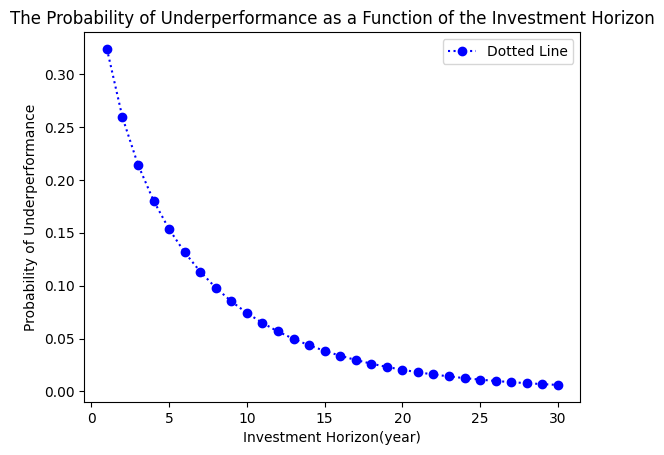

In [ ]:
# Question 2.3 Code Here
p_list = []
h_list = [i for i in range(1, 31)]
SR = m_stats_65_99["r^_m"]/ v_stats_65_99["r^_m"]
for h in h_list:
    p_list.append(norm.cdf(-SR * np.sqrt(h)))

import matplotlib.pyplot as plt


plt.plot(h_list, p_list, linestyle=':', color='blue', marker='o', label='Dotted Line')

plt.title('The Probability of Underperformance as a Function of the Investment Horizon')
plt.xlabel('Investment Horizon(year)')
plt.ylabel('Probability of Underperformance')
plt.legend()

plt.show()


-----

### 3. Full Sample Analysis

Use the sample 1965-{END_YR} to reconsider the 30-year probability. 

As of the end of {END_YR}, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. 

That is, $R^m_{t,t+h}$ underperforming $R^f_{t,t+h}$ for $0<h\le 30$.

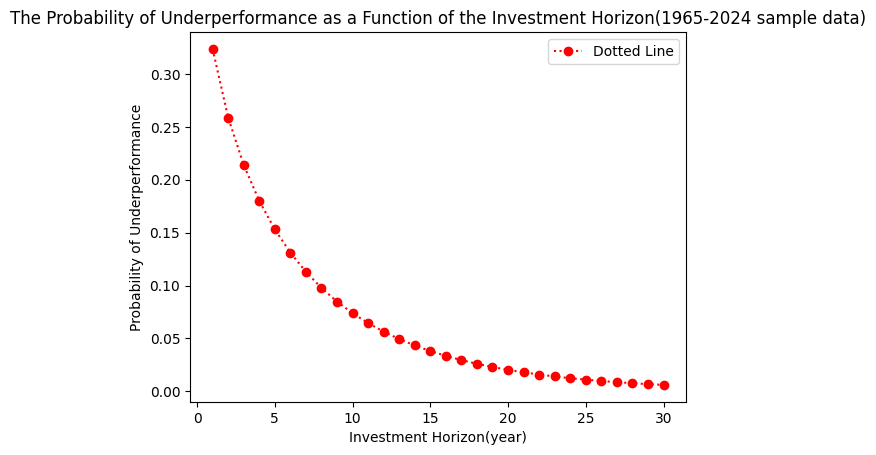

In [13]:
# Question 3 Code Here

sub_df_2 = df[(df["year"] >= 1965) & (df["year"] <= 2024)].copy()
sub_df_2.reset_index(inplace= True)

p_list_2 = []
h_list_2 = [i for i in range(1, 31)]
SR_2 = sub_df_2["r^_m"].mean() / sub_df_2["r^_m"].std() * np.sqrt(12)
for h in h_list_2:
    p_list_2.append(norm.cdf(-SR_2 * np.sqrt(h)))

#import matplotlib.pyplot as plt

plt.plot(h_list_2, p_list_2, linestyle=':', color='red', marker='o', label='Dotted Line')

plt.title('The Probability of Underperformance as a Function of the Investment Horizon(1965-2024 sample data)')
plt.xlabel('Investment Horizon(year)')
plt.ylabel('Probability of Underperformance')
plt.legend()

plt.show()

In [ ]:
# Checking, as the graphs look similar. They actually have similar Sharp Ratio
SR, SR_2

(np.float64(0.4570399214010738), np.float64(0.4576755123063914))

-----

### 4. In-Sample Estimate of Out-of-Sample Likelihood

Let's consider how things turned out relative to Barnstable's 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$) that the `h`-year market return, $R^m_{t,t+h}$, would be smaller than that realized in `2000-{END_YR}`? 

**Hint**: You can calculate this as:

$$p = \Phi_{\mathcal{N}}\left(\sqrt{h}\; \frac{\bar{\texttt{r}}_{out-of-sample} - \bar{\texttt{r}}_{\text{in-sample}}}{\sigma_{\text{in-sample}}}\right)$$

where "in-sample" denotes 1965-1999 and "out-of-sample" denotes 2000-{END_YR}.

In [1]:
# Question 4 Code Here
